In [1]:
from transformers import pipeline, BartTokenizer, BartForConditionalGeneration
import numpy as np
import matplotlib.pyplot as plt

# METHOD 1: Pipeline approach

In [2]:
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Device set to use cpu


In [3]:
incident_text = """
On June 5, 2024, Unit 3 experienced a temporary loss of power due to a failed generator control module.
Operators responded immediately and shifted cooling operations to backup systems.
No radiation was released. The NRC was notified, and full power was restored within 3 hours.
Investigation revealed that the failure was due to aged circuit components.
"""

In [4]:
summary = summarizer(incident_text, max_length=100, min_length=30, do_sample=False)
print(summary[0]['summary_text'])

Your max_length is set to 100, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


 Unit 3 experienced a temporary loss of power due to a failed generator control module . Operators responded immediately and shifted cooling operations to backup systems . Full power was restored within 3 hours .


# METHOD 2: Manual approach

In [5]:
#  DEFINE tokenizer and model FIRST
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained(
    "facebook/bart-large-cnn",
    attn_implementation="eager"
)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [6]:
inputs = tokenizer(incident_text, return_tensors="pt", truncation=True, max_length=1024)

output = model.generate(
    **inputs,
    max_length=50,
    min_length=20,
    num_beams=4,
    early_stopping=True,
    output_attentions=True,
    return_dict_in_generate=True
)

In [7]:
# Decode the summary
summary_text = tokenizer.decode(output['sequences'][0], skip_special_tokens=True)
print("Summary:", summary_text)


Summary: On June 5, 2024, Unit 3 experienced a temporary loss of power due to a failed generator control module. No radiation was released. Full power was restored within 3 hours.


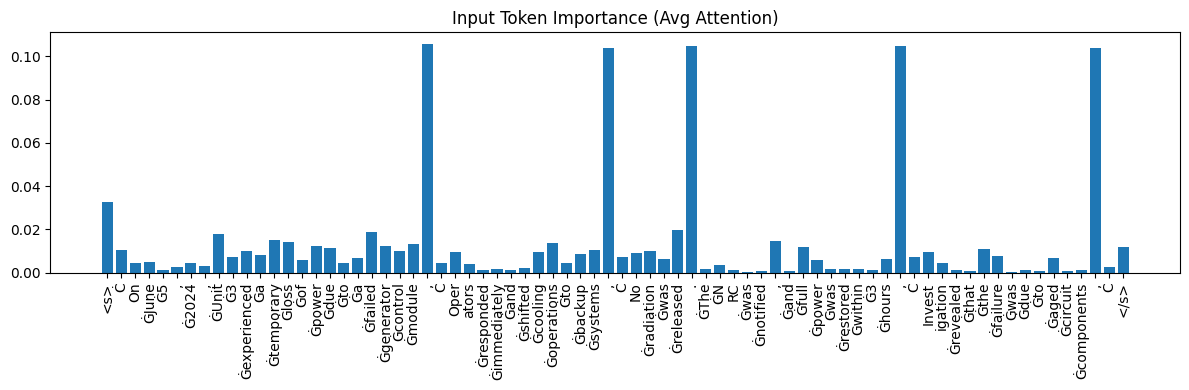

In [8]:
# Attention analysis
if output.cross_attentions and len(output.cross_attentions) > 0:

    all_attentions = []
    for step_attn in output.cross_attentions:
        step_attention = step_attn[-1][0].mean(dim=0).squeeze()
        all_attentions.append(step_attention.detach().numpy())

    avg_attn = np.mean(all_attentions, axis=0)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Create visualization
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(tokens)), avg_attn)
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.title("Input Token Importance (Avg Attention)")
    plt.tight_layout()
    plt.show()
else:
    print("No attention data available")